In [1]:
from src.utils import create_square, plot_function, plot_vector_field
from src.models.dynamics_models import BidomainModel
from src.models.cell_models import *
from typing import Callable
import numpy as np
import ufl

In [2]:
domain = create_square(32, 32)
cell_model = BeelerReuter(domain=domain)


class Model(BidomainModel):
    def initial_V_m(self) -> tuple[Callable, float, float]:
        return lambda x: x[0] ** 2 + x[1] ** 2 < 0.2**2, -60, -84

    # def ischemia(self):
    #    return (
    #        lambda x: (x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2 < 0.5**2,
    #        self.M_i / 10,
    #        self.M_e / 10,
    #    )


model = Model(domain, cell_model)

### Solve the equations with given parameters

In [3]:
model.solve(
    T=10,
    steps=200,
    gif_name="demo.gif",
    signal_point=[0.2, 0.2, 0.0],
)

Solving problem: 100%|██████████| 200/200 [00:17<00:00, 11.54it/s]


### Plotting a final plot of transmembrane potential

In [4]:
plot_function(model.V_m_n, 'V_m')

Widget(value='<iframe src="http://localhost:33215/index.html?ui=P_0x7ff45bfe9c10_0&reconnect=auto" class="pyvi…

### Plotting a transmembrane potential in a given signal point

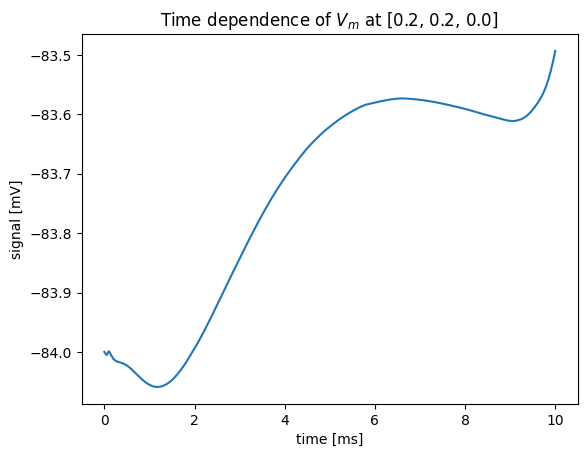

In [5]:
model.plot_signal()

### Plotting a transmembrane potential solution of a cell model

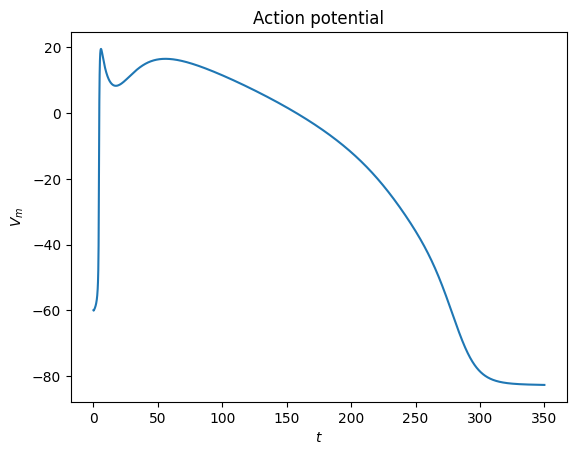

U trenutku T: V= -82.72437458439116 c= 2.575620392842732 m= 0.013953134510476776 h= 0.9774631317498256 j= 0.8936758746717715 d= 0.003607181300894539 f= 0.9109031240861019 x= 0.2651675418869019


In [6]:
cell_model.visualize(350, -60)

In [7]:
plot_vector_field(domain, lambda x: [x[0], x[0], 0])

Widget(value='<iframe src="http://localhost:33215/index.html?ui=P_0x7ff4344fd950_1&reconnect=auto" class="pyvi…